In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import igraph

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.0 anndata==0.7.5 umap==0.5.1 numpy==1.20.1 scipy==1.5.3 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [43]:
results_file = 'write/210816_CS20_processing.h5ad'

In [4]:
adata = sc.read_10x_mtx(
    '/mnt/d/Nishino/DRY/data/analysis/JAGGED1/210414_human_Liver_CS20/processed/cellranger/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)           

... writing an h5ad cache file to speedup reading next time


In [5]:
adata

AnnData object with n_obs × n_vars = 13802 × 36601
    var: 'gene_ids', 'feature_types'

normalizing counts per cell
    finished (0:00:00)


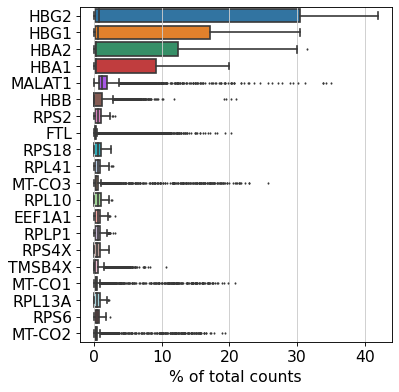

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [13]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
adata.var['hb'] = adata.var_names.str.startswith(("HBA","HBB","HBG"))

In [14]:
adata.var

,gene_ids,feature_types,mt,ribo,hb,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,False,False,False,0,0.000000,100.000000,0.0
FAM138A,ENSG00000237613,Gene Expression,False,False,False,0,0.000000,100.000000,0.0
OR4F5,ENSG00000186092,Gene Expression,False,False,False,0,0.000000,100.000000,0.0
AL627309.1,ENSG00000238009,Gene Expression,False,False,False,3,0.000217,99.978264,3.0
AL627309.3,ENSG00000239945,Gene Expression,False,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,False,False,False,0,0.000000,100.000000,0.0
AC023491.2,ENSG00000278633,Gene Expression,False,False,False,0,0.000000,100.000000,0.0
AC007325.1,ENSG00000276017,Gene Expression,False,False,False,0,0.000000,100.000000,0.0
AC007325.4,ENSG00000278817,Gene Expression,False,False,False,135,0.009926,99.021881,137.0


In [15]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [16]:
adata

AnnData object with n_obs × n_vars = 13802 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

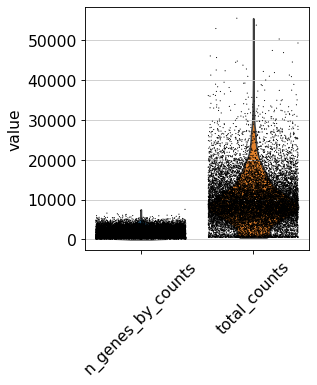

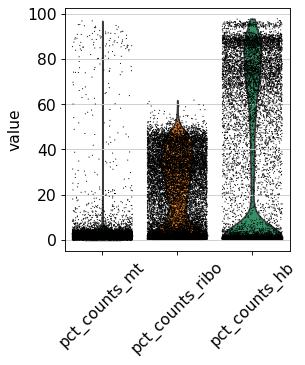

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, rotation= 45)
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'], jitter=0.4, rotation= 45)

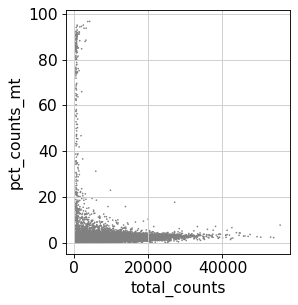

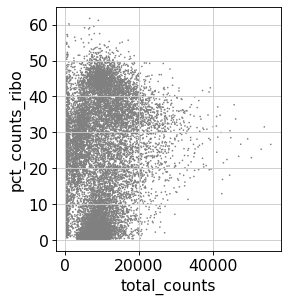

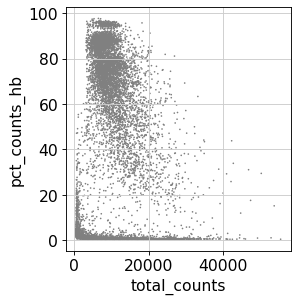

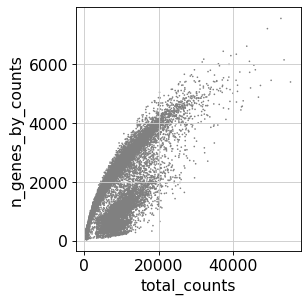

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_hb')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [29]:
adata = adata[adata.obs['pct_counts_mt'] < 10, :]
adata = adata[adata.obs['pct_counts_ribo'] > 10, :]
adata = adata[adata.obs['pct_counts_hb'] < 10, :]

/home/analysis/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/analysis/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/analysis/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [30]:
adata

View of AnnData object with n_obs × n_vars = 7146 × 20959
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [31]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Trying to set attribute `.obs` of view, copying.
filtered out 327 genes that are detected in less than 3 cells


In [32]:
adata

AnnData object with n_obs × n_vars = 7146 × 20632
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

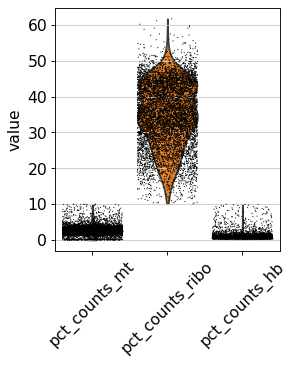

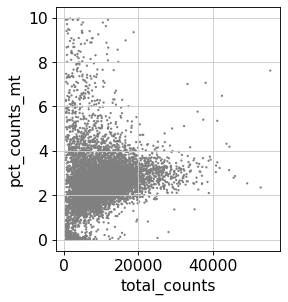

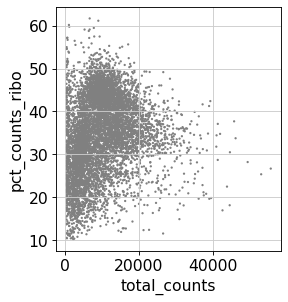

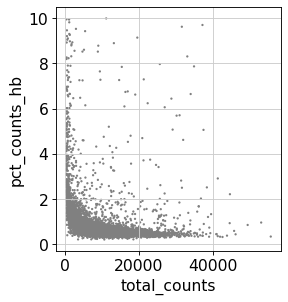

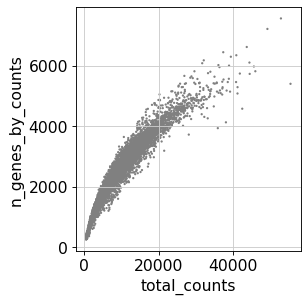

In [33]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'], jitter=0.4, rotation= 45)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_hb')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [35]:
malat1 = adata.var_names.str.startswith('MALAT1')
mito_genes = adata.var_names.str.startswith('MT-')
hb_genes = adata.var_names.str.startswith(('HBA','HBB','HBG'))

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

7146 20613


/home/analysis/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [36]:
adata.raw = adata

In [37]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 23.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.0%
Elapsed time: 7.0 seconds


118

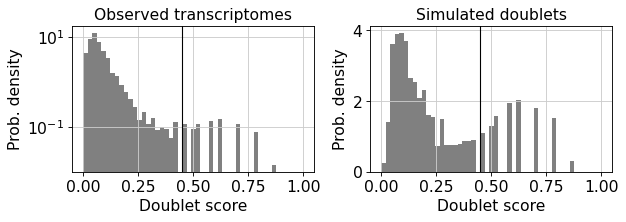

In [38]:
import scrublet as scr
scrub = scr.Scrublet(adata.raw.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [39]:
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


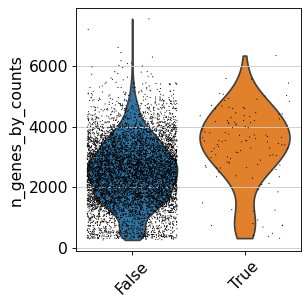

In [40]:
sc.pl.violin(adata, 'n_genes_by_counts',
             jitter=0.4, groupby = 'doublet_info', rotation=45)

In [41]:
adata = adata.raw.to_adata() 

adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)

(7028, 20613)


/home/analysis/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [42]:
adata.write(results_file)